# Orientation classification of cMRI image data on the basis of DICOM

### Introduction

Visualization of each organ by MRI is largely a function of imaging planes. The best dipiction of the specific tissues is possible when the imaging plane is perpendicular to the region of interest.
Currently, when using the cMRI, the following imaging plane are available;

* Standard planes : colonal(A), sagital(B), and axial plane(C) (three orthogonal plane, and doesn't follow the cardiac orientation)
* modified planes : Along with the heart orientation ...Short axis(transverse axis perpendicular to the VS), Long axis 2/3/4 cavities, Multiplanar

※ventricular septum(VS) : the stout wall separating the ventricles, the lower chambers of the heart from one another

※Left ventricular (LV)

Recognition of such orientations or “cardiac views” is a prerequisite for computer-aided diagnosis and for computerassisted workflow automation based on image contents. The goal of this study is to automatically classify cardiac MR images with respect to what view of the heart they contain.

### Each modified image plane
#### 1. short axis
Short axis slices are oriented __perpendicular to LV long axis__.These are acquired regularly spaced from the cardiac base to the apex of the heart, often as __a cine 3D+t stack__. These views are excellent for reproducible volumetric measurements or radial cardiac motion analysis.
#### 2. long axis (2,3,4 cavities(chambers))
The long axis slices are usually acquired as __2D static images or cine 2D+t stacks__. Three types of long axis image are created from short-axis images in order to visualize the chambers in heart(The following figure4). The 2-chamber, 3-chamber, and 4-chamber views are used to visualise different regions of the left ventricle (LV), mitral valve (MV) apparatus, aortic root and left atrium (LA). The 3-chamber and the Left ventricular outflow tract (LVOT) views provide visualisation of the aortic root from two orthogonal planes and help to detect any obstructions of the outflow tract and/or aortic valve (AV) regurgitation. The 4-chamber view visualises both atrio-ventricular valves, all four cardiac chambers and their interplay.
#### 3. Multi plannar(3 types; multiplannar, multiplanner(short axis), and multiplanner(radical)) and None label
Multiplanar orientation is just a collection of different singular orientations. None is a label that identify sequences that are composed by items different from pure image. Usually there is a result report, or a mosaic imageof key elements.


### Dataset
As dataset of cMRI, we can use the excel file including some features on the basis of DICOM metadata. In order to implement the automatical algorithm to recognize the cMRI orientartion, we can use these DICOM-derived features(the image plane orientation vectors) and imageen-derived features.
In the data, there are multiple MRI image which were taken on the basis of 9 different imaging planes(labels in this time).

In [1]:
# Data package for deep learning
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

np.random.seed(123)

Using TensorFlow backend.


In [2]:
from google.colab import files
uploaded = files.upload()


Saving Test_technique.xlsx to Test_technique.xlsx


In [3]:
# Data input
import pandas as pd
df = pd.read_excel('Test_technique.xlsx')
df.head()

,PatientName,StudyInstanceUID,NumberOfSeriesInStudy,SeriesDescription,SeriesInstanceUID,SeriesNumber,ImageSize,PixelSpacing,SliceThickness,ImagePositionPatient,ImageOrientationPatient,SliceLocation,FlipAngle,TriggerTime,EchoTime,RepetitionTime,CartesianNormalVector,SphericalNormalVector,Format,Orientation,Organ
0,Ijifa_224_GO,1.2.124.113532.10.160.226.57.20150729.151548.7...,1,Localizer_Pseudo_SAX,1.2.840.113704.7.32.0.2.18.41095.2015110413342...,3,"[[256, 256]]","[[1.5625, 1.5625]]",8,"[[-200.63540710429, -85.56523264413, 11.427837...","[[[0.78486097661673, -3.763314e-09, 0.61967188...","[55.79317092895508, -11.40682601928711, -0.206...",[68.0],"[162.5, 160.0, 412.5, 417.5, 480.0, 170.0, 262...",[1.100000023841858],[249.27000427246094],"[[-0.4969739551138094, 0.597330308291177, 0.62...","[[2.264742374420166, 0.680851399898529]]",3D,Short Axis,Thorax & Abdomen
1,Ijifa_204_BJC,1.2.124.113532.10.160.226.57.20150805.133941.7...,78,DefineSAX_PA,1.2.840.113704.7.32.0.2.18.41095.2016012513414...,5,"[[256, 256]]","[[1.953125, 1.953125]]",7,"[[23.942903443096, -172.71910443149, 314.50556...","[[[0.49265794684907, 0.81705595917421, -0.2995...","[-17.19231414794922, 45.80768585205078, 56.307...",[80.0],"[802.5, 805.0, 807.5]",[1.059999942779541],[242.4199981689453],"[[-0.698158507616251, 0.576558374822477, 0.424...","[[2.451300621032715, 0.4383509159088135]]",3D,Short Axis,Heart
2,Ijifa_204_BJC,1.2.124.113532.10.160.226.57.20150805.133941.7...,78,T1Map_LongT1_PA_b3s_PA_b2s_PA_b1s_MOCO_T1,1.2.840.113704.7.32.0.2.18.41095.2016012513555...,36,"[[256, 180]]","[[1.5625, 1.5625]]",8,"[[72.179729584959, -102.20561266346, 212.10701...","[[[0.52453054475053, 0.81541979079249, -0.2448...","[19.292226791381836, 41.51932144165039, -1.235...",[35.0],[885.0],[],[],"[[-0.698158471807469, 0.5765583861946223, 0.42...","[[2.4513003826141357, 0.43835094571113586], [2...",3D+TI,Multiplanar (Short axis),Heart
3,Ijifa_204_BJC,1.2.124.113532.10.160.226.57.20150805.133941.7...,78,CINE_segmented_SAX_PA_b6,1.2.840.113704.7.32.0.2.18.41095.2016012514271...,60,"[[288, 240]]","[[1.3194444179534912, 1.3194444179534912]]",7,"[[47.740761582602, -116.99462113737, 212.74662...","[[[0.52453054475053, 0.81541979079249, -0.2448...",[10.485198974609375],[54.0],"[91.12000274658203, 45.560001373291016, 364.48...",[1.2300000190734863],[59.20000076293945],"[[-0.698158471807469, 0.5765583861946223, 0.42...","[[2.4513003826141357, 0.43835094571113586]]",2D+t,Short Axis,Heart
4,Ijifa_204_BJC,1.2.124.113532.10.160.226.57.20150805.133941.7...,78,Q_flow Aorte tubulaire_150_tp_retro_bh_ePAT@c ...,1.2.840.113704.7.32.05.2.18.41095.201601251353...,28,"[[132, 192]]","[[1.7708333730697632, 1.7708333730697632]]",8,"[[-172.1453537941, -85.152832580976, 90.591166...","[[[1.0, 0.0, 0.0], [0.0, 0.99950656036366, 0.0...",[93.22117614746094],[20.0],"[184.0, 165.59999084472656, 1048.7999267578125...",[2.440000057220459],[18.1200008392334],"[[0.0, -0.03141075914411, 0.99950656036366]]","[[-1.5707963705062866, 1.539380431175232]]",2D+t,Axial,Aorta


### Explanation of each data(21 different data)
- Series: "Series" is more or less one acquisition from the MRI that gives a consistent pack of images. When a patient undergoes an imaging session, multiples series(sequencies) are usually acquired, forming what is called a "Study" in DICOM standard. The series number is usually the index of the serie in the study, but than not mandatory. This is information that we extracted from our data, but that is not useful to this work. In addition,‘SeriesDescription’ field, which may contain substrings“2cv” or “2chamber” indicating a two-chamber view,“4cv” or “4chamber” indicating a four-chamber view. However, such a coding scheme, if not missing completely, may be in different languages, and are usually hospital, scanner, and/or user dependent; hence unreliable.

- pixel-spacing: the distance between centers of two adjacent pixels (unit:mm)

- Image Position(Patients): it specifies the x, y, and z coordinates of the upper left hand corner of the image; it is the center of the first voxel transmitted. Regarding the first voxel transmitted, this is the first voxel of the pixel buffer, which is the upper-left one of images.

- Image orientation : it encodes the orientation(direction cosine) of the MRI slice plane in the patient coordinate. This information can serve as a good pre-filter (i.e., provide a good prior), although diseases and abnormalities abound, and some views are more easily confused with others. Furthermore, noncardiac images may have these orientations as well.

- Flip angle : it is the angle which the hydrogen spin is altered when applying the RF signal into the subject. If the flip angle is 90 degree, the hydrogen spin is completely projected into transverse(xy) plane.

- Normal vector(Cartesian, spherical) : it is the third orthogonal vector of the matrix, which is perpendicular to the image plane. Normal vectors are the result of cross product (and not dot product) of the two first vector (in-plane vector), so yes they are perpendicular to the image plane. That explains why non-multiplanar sequence have only one normal vector. 

In [4]:
## data infomation
df.info()
df.nunique()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12602 entries, 0 to 12601
Data columns (total 21 columns):
PatientName                12602 non-null object
StudyInstanceUID           12602 non-null object
NumberOfSeriesInStudy      12602 non-null int64
SeriesDescription          12601 non-null object
SeriesInstanceUID          12602 non-null object
SeriesNumber               12602 non-null int64
ImageSize                  12602 non-null object
PixelSpacing               12602 non-null object
SliceThickness             12602 non-null object
ImagePositionPatient       12602 non-null object
ImageOrientationPatient    12602 non-null object
SliceLocation              12602 non-null object
FlipAngle                  12602 non-null object
TriggerTime                12602 non-null object
EchoTime                   12602 non-null object
RepetitionTime             12602 non-null object
CartesianNormalVector      12602 non-null object
SphericalNormalVector      12602 non-null object
Format     

Index(['PatientName', 'StudyInstanceUID', 'NumberOfSeriesInStudy',
       'SeriesDescription', 'SeriesInstanceUID', 'SeriesNumber', 'ImageSize',
       'PixelSpacing', 'SliceThickness', 'ImagePositionPatient',
       'ImageOrientationPatient', 'SliceLocation', 'FlipAngle', 'TriggerTime',
       'EchoTime', 'RepetitionTime', 'CartesianNormalVector',
       'SphericalNormalVector', 'Format', 'Orientation', 'Organ'],
      dtype='object')

In [5]:
# labeling (orientation) : we just try to invert each label into the code(0-10)
orientation_type_dict = {
    'Short Axis': 'SH',
    'Axial':'AL',
    'Sagittal':'SG',
    'Coronal':'CR',
    'Long Axis 2 Cavities':'LG2',
    'Long Axis 3 Cavities':'LG3',
    'Long Axis 4 Cavities':'LG4',
    'Multiplanar':'ML1',
    'Multiplanar (Short axis)':'ML2',
    'Multiplanar (Radial)':'ML3',
    'None':'NO'}

# Creating New Columns for better readability

df['orientation_1'] = df['Orientation'].map(orientation_type_dict.get) 
df['orientation_index'] = pd.Categorical(df['orientation_1']).codes
df

,PatientName,StudyInstanceUID,NumberOfSeriesInStudy,SeriesDescription,SeriesInstanceUID,SeriesNumber,ImageSize,PixelSpacing,SliceThickness,ImagePositionPatient,ImageOrientationPatient,SliceLocation,FlipAngle,TriggerTime,EchoTime,RepetitionTime,CartesianNormalVector,SphericalNormalVector,Format,Orientation,Organ,orientation_1,orientation_index
0,Ijifa_224_GO,1.2.124.113532.10.160.226.57.20150729.151548.7...,1,Localizer_Pseudo_SAX,1.2.840.113704.7.32.0.2.18.41095.2015110413342...,3,"[[256, 256]]","[[1.5625, 1.5625]]",8,"[[-200.63540710429, -85.56523264413, 11.427837...","[[[0.78486097661673, -3.763314e-09, 0.61967188...","[55.79317092895508, -11.40682601928711, -0.206...",[68.0],"[162.5, 160.0, 412.5, 417.5, 480.0, 170.0, 262...",[1.100000023841858],[249.27000427246094],"[[-0.4969739551138094, 0.597330308291177, 0.62...","[[2.264742374420166, 0.680851399898529]]",3D,Short Axis,Thorax & Abdomen,SH,10
1,Ijifa_204_BJC,1.2.124.113532.10.160.226.57.20150805.133941.7...,78,DefineSAX_PA,1.2.840.113704.7.32.0.2.18.41095.2016012513414...,5,"[[256, 256]]","[[1.953125, 1.953125]]",7,"[[23.942903443096, -172.71910443149, 314.50556...","[[[0.49265794684907, 0.81705595917421, -0.2995...","[-17.19231414794922, 45.80768585205078, 56.307...",[80.0],"[802.5, 805.0, 807.5]",[1.059999942779541],[242.4199981689453],"[[-0.698158507616251, 0.576558374822477, 0.424...","[[2.451300621032715, 0.4383509159088135]]",3D,Short Axis,Heart,SH,10
2,Ijifa_204_BJC,1.2.124.113532.10.160.226.57.20150805.133941.7...,78,T1Map_LongT1_PA_b3s_PA_b2s_PA_b1s_MOCO_T1,1.2.840.113704.7.32.0.2.18.41095.2016012513555...,36,"[[256, 180]]","[[1.5625, 1.5625]]",8,"[[72.179729584959, -102.20561266346, 212.10701...","[[[0.52453054475053, 0.81541979079249, -0.2448...","[19.292226791381836, 41.51932144165039, -1.235...",[35.0],[885.0],[],[],"[[-0.698158471807469, 0.5765583861946223, 0.42...","[[2.4513003826141357, 0.43835094571113586], [2...",3D+TI,Multiplanar (Short axis),Heart,ML2,6
3,Ijifa_204_BJC,1.2.124.113532.10.160.226.57.20150805.133941.7...,78,CINE_segmented_SAX_PA_b6,1.2.840.113704.7.32.0.2.18.41095.2016012514271...,60,"[[288, 240]]","[[1.3194444179534912, 1.3194444179534912]]",7,"[[47.740761582602, -116.99462113737, 212.74662...","[[[0.52453054475053, 0.81541979079249, -0.2448...",[10.485198974609375],[54.0],"[91.12000274658203, 45.560001373291016, 364.48...",[1.2300000190734863],[59.20000076293945],"[[-0.698158471807469, 0.5765583861946223, 0.42...","[[2.4513003826141357, 0.43835094571113586]]",2D+t,Short Axis,Heart,SH,10
4,Ijifa_204_BJC,1.2.124.113532.10.160.226.57.20150805.133941.7...,78,Q_flow Aorte tubulaire_150_tp_retro_bh_ePAT@c ...,1.2.840.113704.7.32.05.2.18.41095.201601251353...,28,"[[132, 192]]","[[1.7708333730697632, 1.7708333730697632]]",8,"[[-172.1453537941, -85.152832580976, 90.591166...","[[[1.0, 0.0, 0.0], [0.0, 0.99950656036366, 0.0...",[93.22117614746094],[20.0],"[184.0, 165.59999084472656, 1048.7999267578125...",[2.440000057220459],[18.1200008392334],"[[0.0, -0.03141075914411, 0.99950656036366]]","[[-1.5707963705062866, 1.539380431175232]]",2D+t,Axial,Aorta,AL,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12597,Ijifa_128_HF,1.2.124.113532.10.160.226.57.20171113.101639.1...,72,Q_flow Aorte tubulaire_150_tp_retro_bh_ePAT@c ...,1.2.840.113704.7.32.0.2.18.41095.2018011713463...,37,"[[132, 192]]","[[2.0833332538604736, 2.0833332538604736]]",8,"[[-198.27125036716, -119.563031654, 14.0392197...","[[[1.0, 0.0, 0.0], [0.0, 0.98713626451576, 0.1...",[32.97450256347656],[20.0],"[323.433349609375, 333.8666687011719, 459.0666...",[2.319999933242798],[17.559999465942383],"[[0.0, -0.15988119113225, 0.98713626451576]]","[[-1.5707963705062866, 1.4102259874343872]]",2D+t,Axial,Aorta,AL,0
12598,Ijifa_128_HF,1.2.124.113532.10.160.226.57.20171113.101639.1...,72,T2Map_TrueFISP_PA_b3s_MOCO,1.2.840.113704.7.32.0.2.18.41095.2018011713341...,16,"[[192, 184]]","[[1.875, 1.875]]",8,"[[51.917082919297, -151.08079213743, 143.99640.

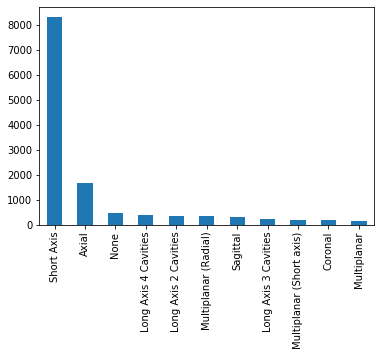

In [6]:
## Check of clustering
df['Orientation'].value_counts().plot(kind='bar')

According to the number of each orientation(label), the data imbalance happens. Thus, it is better to regulate the data-imbalance in the step of deep learning(Down-sampling).

## Data plot

Firstly, we try to see whether each data has cluster or not by plotting the normalized or spherical vector.

In [0]:
## Extraction of each labeled data

SH = df.query('Orientation == "Short Axis"')

AL = df.query('Orientation == "Axial"')

SG = df.query('Orientation == "Sagittal"')

CO = df.query('Orientation == "Coronal"')

LG2 = df.query('Orientation == "Long Axis 2 Cavities"')

LG3 = df.query('Orientation == "Long Axis 3 Cavities"')

LG4 = df.query('Orientation == "Long Axis 4 Cavities"')

ML1 = df.query('Orientation == "Multiplanar"')

ML2 = df.query('Orientation == "Multiplanar (Short axis)"')

ML3 = df.query('Orientation == "Multiplanar (Radial)"')

NO = df.query('Orientation == "None"')


#### Cartesian Normal vector(3d) plotting 

In [0]:
# Pick up only for Normal vector

SH_1 = SH.loc[:,'CartesianNormalVector']
AL_1 = AL.loc[:,'CartesianNormalVector']
SG_1 = SG.loc[:,'CartesianNormalVector']
CO_1 = CO.loc[:,'CartesianNormalVector']
LG2_1 = LG2.loc[:,'CartesianNormalVector']
LG3_1 = LG3.loc[:,'CartesianNormalVector']
LG4_1 = LG4.loc[:,'CartesianNormalVector']
ML1_1 = ML1.loc[:,'CartesianNormalVector']
ML2_1 = ML2.loc[:,'CartesianNormalVector']
ML3_1 = ML3.loc[:,'CartesianNormalVector']
NO_1 =NO.loc[:,'CartesianNormalVector']


In [0]:
# renumbering of index
SH_2=SH_1.reset_index()
AL_2=AL_1.reset_index()
SG_2=SG_1.reset_index()
CO_2=CO_1.reset_index()
LG2_2=LG2_1.reset_index()
LG3_2=LG3_1.reset_index()
LG4_2 = LG4_1.reset_index()
ML1_2 = ML1_1.reset_index()
ML2_2 = ML2_1.reset_index()
ML3_2 = ML3_1.reset_index()
NO_2 = NO_1.reset_index()


Here, each data is String type, so we need to change it into the float type by using the following algorithm

In [10]:
# The problem is that CartesianNormalVector is str type, thus we need to convert them into the string type.

A = SH_2.iloc[0,1]
print(A)
print(type(A))
# First comma
a = A.find(',')
# Second comma
b = A.find(',',a+1)
# final parenthesis
c = A.find(']',b+1)

Ax = float(A[2:a])
Ay = float(A[a+2:b])
Az = float(A[b+2:c])

print(Ax)
print(Ay)
print(Az)
print(type(Ax))

[[-0.4969739551138094, 0.597330308291177, 0.6294548361362254]]
<class 'str'>
-0.4969739551138094
0.597330308291177
0.6294548361362254
<class 'float'>


In [0]:
# The program to return the String data(3d)

def StrC(x1):
    AX = np.zeros(len(x1))
    AY = np.zeros(len(x1))
    AZ = np.zeros(len(x1))
    for i in range(len(x1)):
        A = x1.iloc[i,1]
        a = A.find(',')
        b = A.find(',',a+1)
        c = A.find(']',b+1)
        Ax = float(A[2:a])
        AX[i] = Ax
        Ay = float(A[a+2:b])
        AY[i] = Ay
        Az = float(A[b+2:c])
        AZ[i] = Az
    
    return AX, AY, AZ

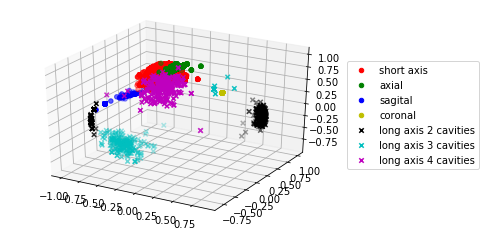

In [12]:
# Check of clustering (I did it for the short axis)
# We just pick up only single plane orientation, thus we must cut out the Multiplannar and None labeling.

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

AX,AY,AZ = StrC(SH_2)
BX,BY,BZ = StrC(AL_2)
CX,CY,CZ = StrC(SG_2)
DX,DY,DZ = StrC(CO_2)
EX,EY,EZ = StrC(LG2_2)
FX,FY,FZ = StrC(LG3_2)
GX,GY,GZ = StrC(LG4_2)

ax.scatter(AX,AY,AZ, c='r', marker='o', label='short axis')
ax.scatter(BX,BY,BZ, c='g', marker='o', label ='axial')
ax.scatter(CX,CY,CZ, c='b', marker='o', label='sagital')
ax.scatter(DX,DY,DZ, c='y', marker='o', label='coronal')
ax.scatter(EX,EY,EZ, c='k', marker='x', label='long axis 2 cavities')
ax.scatter(FX,FY,FZ, c='c', marker='x', label='long axis 3 cavities')
ax.scatter(GX,GY,GZ, c='m', marker='x', label='long axis 4 cavities')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### for the spherical vector(2d) plotting

In [0]:
SH_3 = SH.loc[:,'SphericalNormalVector']
AL_3 = AL.loc[:,'SphericalNormalVector']
SG_3 = SG.loc[:,'SphericalNormalVector']
CO_3 = CO.loc[:,'SphericalNormalVector']
LG2_3 = LG2.loc[:,'SphericalNormalVector']
LG3_3 = LG3.loc[:,'SphericalNormalVector']
LG4_3 = LG4.loc[:,'SphericalNormalVector']

SH_4=SH_3.reset_index()
AL_4=AL_3.reset_index()
SG_4=SG_3.reset_index()
CO_4=CO_3.reset_index()
LG2_4=LG2_3.reset_index()
LG3_4=LG3_3.reset_index()
LG4_4=LG4_3.reset_index()

In [0]:
def StrC1(x1):
    AX = np.zeros(len(x1))
    AY = np.zeros(len(x1))
    for i in range(len(x1)):
        A = x1.iloc[i,1]
        a = A.find(',')
        b = A.find(']',a+1)
        Ax = float(A[2:a])
        AX[i] = Ax
        Ay = float(A[a+2:b])
        AY[i] = Ay
    
    return AX, AY

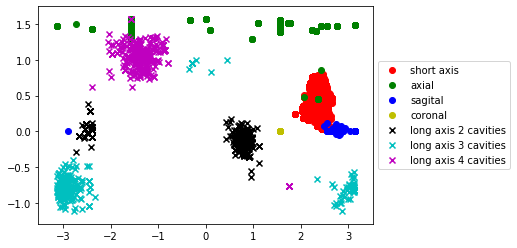

In [15]:
# Check of clustering (I did it for the short axis)
# We just pick up only single plane orientation, thus we must cut out the Multiplannar and None labeling.

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure()
ax = fig.add_subplot(111)

AX1,AY1 = StrC1(SH_4)
BX1,BY1 = StrC1(AL_4)
CX1,CY1 = StrC1(SG_4)
DX1,DY1 = StrC1(CO_4)
EX1,EY1 = StrC1(LG2_4)
FX1,FY1 = StrC1(LG3_4)
GX1,GY1 = StrC1(LG4_4)

ax.scatter(AX1,AY1, c='r', marker='o', label='short axis')
ax.scatter(BX1,BY1, c='g', marker='o', label ='axial')
ax.scatter(CX1,CY1, c='b', marker='o', label='sagital')
ax.scatter(DX1,DY1, c='y', marker='o', label='coronal')
ax.scatter(EX1,EY1, c='k', marker='x', label='long axis 2 cavities')
ax.scatter(FX1,FY1, c='c', marker='x', label='long axis 3 cavities')
ax.scatter(GX1,GY1, c='m', marker='x', label='long axis 4 cavities')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Thus, in the result of plotting for normal cartesian vector and spherial normal vector, the data has clusters depending on the label. Thus, we can develop the neural network to recognise the image plane by using these vector as features.

## Construction of neural network

### Data preparation (Creating the feature matrices and labeling)
The candidate of feature should be image position patient, ImageOrientationPatient, CartesianNormalVector, and SphericalNormalVector. But these parameter are dependent each other, so as a first trial, we can use only CartesianNormalVector since their position has some tendency in the previous plotting result.

Thus, we create the 3d matrices, including the number of data(12602), the number of vectors(almost 1 vector, but multiplanner has some different vectors), and the number of coordinate position(x,y,z=3).

And one note is that in the case which the number of vectors is 1, the other element is 0.

Firstly, we try to find the maximum number of vectors in the case of multiplanner, in order to create the framework of 3d matrices.

In [16]:
## Maximum number of vector
def MaxVector(x1):
    for i in range(len(x1)):
      A = x1.iloc[i,1]
      a = A.count('[')
    return a-1 # the number of vector should one less than the number of parenthesis. 

print(MaxVector(SH_2))
print(MaxVector(ML1_2))
print(MaxVector(ML2_2))
print(MaxVector(ML3_2))
print(MaxVector(NO_2))

1
4
3
12
0


Thus, the maximum number of vectors is 12. Thus, we must create the 3d matrix (12602/Number of data, 12/Number of vector, 3/Number of coordinate(x,y,z))

Next, i create the algorithm to extract the element of vector from String type.

In [0]:
def NOR(x1):
    AX = np.zeros((len(x1),12))
    AY = np.zeros((len(x1),12))
    AZ = np.zeros((len(x1),12))
    for i in range(len(x1)):
        A = x1.iloc[i,1]
        N = A.count('[')
        if N==1:
          pass
          
        elif N==2:
          a = -2
          for j in range(N-1):
            a = a+4
            b = A.find(',',a+1)
            Ax = float(A[a:b])
            AX[i,j] = Ax
            c = A.find(',',b+1)
            Ay = float(A[b+2:c])
            AY[i,j] = Ay
            a = A.find(']',c+1)
            Az = float(A[c+2:a])
            AZ[i,j] = Az

        elif N==3:
            a = -2
            for j in range(N-1):
              a = a+4
              b = A.find(',',a+1)
              Ax = float(A[a:b])
              AX[i,j] = Ax
              c = A.find(',',b+1)
              Ay = float(A[b+2:c])
              AY[i,j] = Ay
              a = A.find(']',c+1)
              Az = float(A[c+2:a])
              AZ[i,j] = Az

        elif N==4:
            a = -2
            for j in range(N-1):
              a = a+4
              b = A.find(',',a+1)
              Ax = float(A[a:b])
              AX[i,j] = Ax
              c = A.find(',',b+1)
              Ay = float(A[b+2:c])
              AY[i,j] = Ay
              a = A.find(']',c+1)
              Az = float(A[c+2:a])
              AZ[i,j] = Az     

        elif N==5:
            a = -2
            for j in range(N-1):
              a = a+4
              b = A.find(',',a+1)
              Ax = float(A[a:b])
              AX[i,j] = Ax
              c = A.find(',',b+1)
              Ay = float(A[b+2:c])
              AY[i,j] = Ay
              a = A.find(']',c+1)
              Az = float(A[c+2:a])
              AZ[i,j] = Az
                  
        elif N==6:
            a = -2
            for j in range(N-1):
              a = a+4
              b = A.find(',',a+1)
              Ax = float(A[a:b])
              AX[i,j] = Ax
              c = A.find(',',b+1)
              Ay = float(A[b+2:c])
              AY[i,j] = Ay
              a = A.find(']',c+1)
              Az = float(A[c+2:a])
              AZ[i,j] = Az

        elif N==7:
            a = -2
            for j in range(N-1):
              a = a+4
              b = A.find(',',a+1)
              Ax = float(A[a:b])
              AX[i,j] = Ax
              c = A.find(',',b+1)
              Ay = float(A[b+2:c])
              AY[i,j] = Ay
              a = A.find(']',c+1)
              Az = float(A[c+2:a])
              AZ[i,j] = Az

        elif N==8:
            a = -2
            for j in range(N-1):
              a = a+4
              b = A.find(',',a+1)
              Ax = float(A[a:b])
              AX[i,j] = Ax
              c = A.find(',',b+1)
              Ay = float(A[b+2:c])
              AY[i,j] = Ay
              a = A.find(']',c+1)
              Az = float(A[c+2:a])
              AZ[i,j] = Az

        elif N==9:
            a = -2
            for j in range(N-1):
              a = a+4
              b = A.find(',',a+1)
              Ax = float(A[a:b])
              AX[i,j] = Ax
              c = A.find(',',b+1)
              Ay = float(A[b+2:c])
              AY[i,j] = Ay
              a = A.find(']',c+1)
              Az = float(A[c+2:a])
              AZ[i,j] = Az

        elif N==10:
            a = -2
            for j in range(N-1):
              a = a+4
              b = A.find(',',a+1)
              Ax = float(A[a:b])
              AX[i,j] = Ax
              c = A.find(',',b+1)
              Ay = float(A[b+2:c])
              AY[i,j] = Ay
              a = A.find(']',c+1)
              Az = float(A[c+2:a])
              AZ[i,j] = Az

        elif N==11:
            a = -2
            for j in range(N-1):
              a = a+4
              b = A.find(',',a+1)
              Ax = float(A[a:b])
              AX[i,j] = Ax
              c = A.find(',',b+1)
              Ay = float(A[b+2:c])
              AY[i,j] = Ay
              a = A.find(']',c+1)
              Az = float(A[c+2:a])
              AZ[i,j] = Az

        elif N==12:
            a = -2
            for j in range(N-1):
              a = a+4
              b = A.find(',',a+1)
              Ax = float(A[a:b])
              AX[i,j] = Ax
              c = A.find(',',b+1)
              Ay = float(A[b+2:c])
              AY[i,j] = Ay
              a = A.find(']',c+1)
              Az = float(A[c+2:a])
              AZ[i,j] = Az

        elif N==13:
            a = -2
            for j in range(N-1):
              a = a+4
              b = A.find(',',a+1)
              Ax = float(A[a:b])
              AX[i,j] = Ax
              c = A.find(',',b+1)
              Ay = float(A[b+2:c])
              AY[i,j] = Ay
              a = A.find(']',c+1)
              Az = float(A[c+2:a])
              AZ[i,j] = Az


    return AX, AY, AZ

In [0]:
# construction of 2d planners

AX,AY,AZ = NOR(SH_2)
BX,BY,BZ = NOR(AL_2)
CX,CY,CZ = NOR(SG_2)
DX,DY,DZ = NOR(CO_2)
EX,EY,EZ = NOR(LG2_2)
FX,FY,FZ = NOR(LG3_2)
GX,GY,GZ = NOR(LG4_2)
HX,HY,HZ = NOR(ML1_2)
IX,IY,IZ = NOR(ML2_2)
JX,JY,JZ = NOR(ML3_2)
KX,KY,KZ = NOR(NO_2)

Next, i append each 2d planner matrix to construct the feature of 3d matrix.

In [19]:
OX = np.vstack((AX,BX,CX,DX,EX,FX,GX,HX,IX,JX,KX))
print(OX)
print(OX.shape)

OY = np.vstack((AY,BY,CY,DY,EY,FY,GY,HY,IY,JY,KY))

OZ = np.vstack((AZ,BZ,CZ,DZ,EZ,FZ,GZ,HZ,IZ,JZ,KZ))

[[-0.49697396  0.          0.         ...  0.          0.
   0.        ]
 [-0.69815851  0.          0.         ...  0.          0.
   0.        ]
 [-0.69815847  0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.64710254 -0.08482931  0.71121863 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(12602, 12)


In [20]:
X = np.dstack((OX,OY,OZ))

print(X.shape)

(12602, 12, 3)


Next, i create the labeling of each orientation (11 classes). For the neural network, we're supposed to use one-hot encorder because this task is multiple-classification.

In [21]:
L0 = np.zeros((len(SH),1))
L1 = np.ones((len(AL),1))
L2 = 2*np.ones((len(SG),1))
L3 = 3*np.ones((len(CO),1))
L4 = 4*np.ones((len(LG2),1))
L5 = 5*np.ones((len(LG3),1))
L6 = 6*np.ones((len(LG4),1))
L7 = 7*np.ones((len(ML1),1))
L8 = 8*np.ones((len(ML2),1))
L9 = 9*np.ones((len(ML3),1))
L10 = 10*np.ones((len(NO),1))

y = np.vstack((L0,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10))
print(y.shape)

(12602, 1)


In [0]:
# one hot encorder for labeling
y=to_categorical(y, num_classes = 11)

Next, the sample is subject to be shuffled to evaluate whether our algorithm work very well or not. And we add one more dimention for feature matrices because in this time, we try to use the CNN and we want to mimic the feature as images.

In [23]:
# shuffling of the data
indeces=np.arange(len(X)) # Integers from 0 to N-1
print(indeces)

np.random.shuffle(indeces)
print(indeces)

Xp=X[indeces]
Yp=y[indeces]

print(Xp)

[    0     1     2 ... 12599 12600 12601]
[10340  9067  7919 ...  1346 11646  3582]
[[[-0.          1.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.56321122  0.74618844  0.35495906]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.66269306  0.59041102  0.46070895]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]


In [24]:
# adding one more dimention

Xp=np.expand_dims(Xp,axis=3)
print(Xp.shape)

(12602, 12, 3, 1)


### Construction of Convolutional network (CNNs)
Firstly, i just splitted the data into training-set, validation-set and test set as follows.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(Xp, Yp, test_size=0.25, random_state=42)

X_train, X_validation, y_train, y_validation =train_test_split(Xp, Yp, test_size=0.25, random_state=42)


In [26]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu] -> Flatten -> Dense -> Dropout -> Out
num_classes = 11
input_shape = X_train[0].shape

#set of CONV => RELU => POOL layers
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu',input_shape =input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))



#flatten and softmax
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=11, activation='softmax'))

# Define the optimizer

keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# Compile the model

model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=["accuracy"])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [27]:
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 3, 16)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 3, 16)         64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 1, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 1, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

Training the CNNs as follows, in this case i did the 50 epochs.

In [28]:
hist=model.fit(Xp,Yp,batch_size=10,validation_split=0.25,nb_epoch=50,shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.




Train on 9451 samples, validate on 3151 samples
Epoch 1/50
9451/9451 [==============================] - 3s 302us/step - loss: 0.4891 - acc: 0.8740 - val_loss: 0.0932 - val_acc: 0.9835
Epoch 2/50
9451/9451 [==============================] - 2s 237us/step - loss: 0.1850 - acc: 0.9475 - val_loss: 0.0697 - val_acc: 0.9835
Epoch 3/50
9451/9451 [==============================] - 2s 233us/step - loss: 0.1335 - acc: 0.9617 - val_loss: 0.0642 - val_acc: 0.9806
Epoch 4/50
9451/9451 [==============================] - 2s 230us/step - loss: 0.1110 - acc: 0.9696 - val_loss: 0.0556 - val_acc: 0.9889
Epoch 5/50
9451/9451 [==============================] - 2s 233us/step - loss: 0.1101 - acc: 0.9709 - val_loss: 0.0512 - val_acc: 0.9898
Epoch 6/50
9451/9451 [==============================] - 2s 234us/step - loss: 0.0952 - acc: 0.9750 - val_loss: 0.0484 - val_acc: 0.9902
Epoch 7/50
9451/9451 [==============================] - 2s 232us/step - loss: 0.0937 - acc: 0.9748 - val_loss: 0.0461 - val_acc: 0.989

The result of training CNNs in terms of accuracy and model loss

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


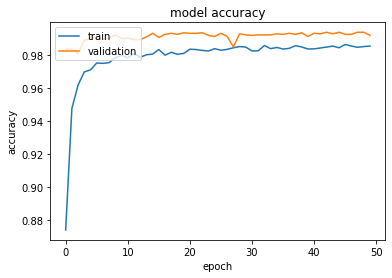

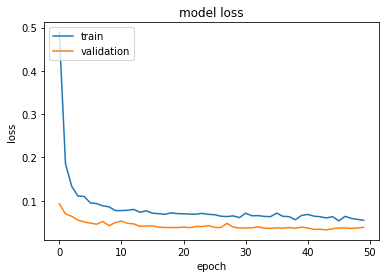

In [29]:
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


### Evaluation of CNNs which i trained to classify the 11 different orientation
Firstly, i created the function of confusion matrix, and i used this CNNs algorithm to predict the data labeling as follows.

In [0]:
## Construction of confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(10, 10), dpi=50)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [31]:
# Predict the values from the validation dataset
y_validate_pred = model.predict(X_validation).round()
print(y_validate_pred)

# Convert predictions classes to one hot vectors 
Y_pred_classes=to_categorical(y_validate_pred, num_classes = 11)

# Convert validation observations to one hot vectors
Y_true=to_categorical(y_validation, num_classes = 11)


# compute the confusion matrix
confusion_mtx = confusion_matrix(y_validation.argmax(axis=1),y_validate_pred.argmax(axis=1))

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


Confusion matrix, without normalization
[[2071    0    0    0    0    0    0    0    0    0    0]
 [   3  425    0    0    0    0    0    0    0    0    0]
 [   0    0   72    0    0    0    0    0    0    0    0]
 [   0    0    0   40    0    0    0    0    0    0    0]
 [   0    0    0    0   88    0    0    0    0    0    0]
 [   1    0    0    0    1   49    0    0    0    0    0]
 [   0    1    0    0    0    0  113    0    0    0    0]
 [   1    0    0    0    0    0    0   41    0    0    0]
 [   0    0    0    0    0    0    0    0   44    0    0]
 [   1    0    0    0    0    0    0    0    1   87    0]
 [   4    0    0    0    0    0    3    2    0    2  101]]


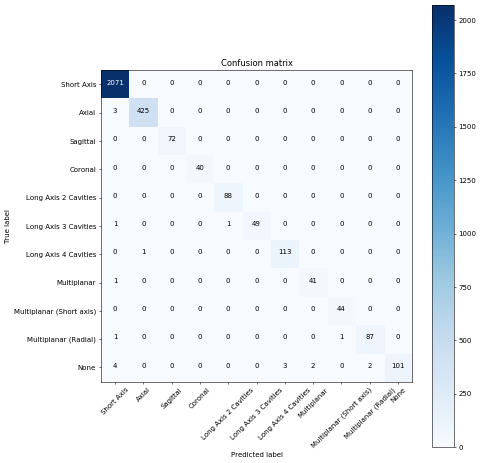

In [32]:
plot_confusion_matrix(confusion_mtx, classes = orientation_type_dict)

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.00700935 0.99299065 0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.        ]
 [0.01960784 0.         0.         0.         0.01960784 0.96078431
  0.         0.         0.         0.         0.        ]
 [0.         0.00877193 0.         0.         0.         0.
  0.99122807 0.         0.         0.         0.        ]
 [0.02380952 0.         0.         0.         0.         0.
  0.         0.97619048 0.         0.         0.        ]
 [0.         0.     

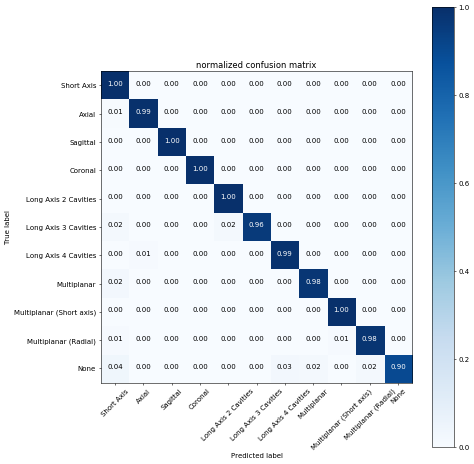

In [33]:
plot_confusion_matrix(confusion_mtx,classes=orientation_type_dict, normalize=True, title='normalized confusion matrix')

Herein, nevertheless i used only cartesian normal vector as features and there were sample-imbalance(majority data is from short-axis), the accuracy of this CNNs algorithm was good (almost 100%).

In the CNNs trainings, the accuracy was converged at around 10-20 epochs.